# Titanic Survival Classification

In this notebook we will attempt to build a model to predict the survival of the passengers of the Titanic

## Project Overview
Let's develop a gameplan for how to build our classification model:

### 1. Understand what we're doing:
* What are we trying to predict?
* What sort of model do we need for this problem? Which scoring method will we use? What score would make the model successful?
* Where are we getting the data from? What are the data characteristics/features?
* What other tools do we need for preprocessing, visualization, etc.?

### 2. Import tools
Import any libraries and other tools that are necessary

### 3. Load and explore the data
Import the data and form some initial impressions. Create a few visualizations to highlight curious/seemingly significant features.

### 4. Clean up the data and split it
Are there missing values? If so, do we fill them in or discard the row? Do we need to transform any data (i.e. from string/object into numerical type)? Are there any features that are seemingly unimportant that we can discard? Finally, split data into train and test splits. 

### 5. Modelling and Evaluation
Instantiate the chosen model and fit it to the training data. Score the model on the test data using the chosen scoring method (and perhaps other scoring methods if they offer insight). You could also fit and score several models at the same time and then move forward with the one that performs best.

### 6. Tune the model
Adjust the model's hyperparameters. Loop through steps 4-6 until the threshold score is reached, or the score plateaus.

### 7. Export the model (if successful)
If the model reaches the prerequisite score to be considered successful, consider exporting the model

### 8. Reflection
Reflect on aspects of the workflow that worked well or needed improvement. Would a different model have been more successful? Were choices made during preprocessing that potentially affected outcome?


## 1. Understand what we're doing

For this project, we are trying to predict which passengers on the Titanic survive and which do not. The data for this project, as well as a data dictionary which explains the features, can be found on Kaggle's Titanic competition page: https://www.kaggle.com/competitions/titanic/

This project involves a classification problem, where the target is a binary classification of 1 for survival, or 0 for deceased. Since this is a classification problem, we will be looking at classification models such as RandomForestClassifier and LogisticRegression (and potentially others). The scoring method we will use will be accuracy (as a percentage), as mentioned on Kaggle's Titanic page. For scoring threshold, we will aim for an accuracy >90%

Tools we will use in this project include classification models and preprocessing tools from Scikit-learn. We will also use Pandas, NumPy, MatPlotLib, Seaborn, and other libraries as necessary.

## 2. Import tools

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Import other tools from sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [112]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [126]:
from sklearn.model_selection import RandomizedSearchCV

In [136]:
from sklearn.model_selection import GridSearchCV

## 3. Load and explore the data

In [6]:
df_train = pd.read_csv("titanic/train.csv")

In [7]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


From this brief glimpse at the dataframe, we can see:
* Target column is "Survived"
* We have non-numeric columns, such as Name and Sex
* We have missing values (NaN values under Cabin)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Notice some of our columns have dtype of 'object'. We will have to transform these to a numeric type before fitting our model. We can do this by using sklearn's transformers or by using pandas' Categorical method

In [9]:
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

So we do indeed have missing values, mostly found in two columns (Age and Cabin) with a couple in Embarked. We will need to fill in or discard these values prior to fitting. Since we've mentioned age, I'm curious what the distribution of ages is:

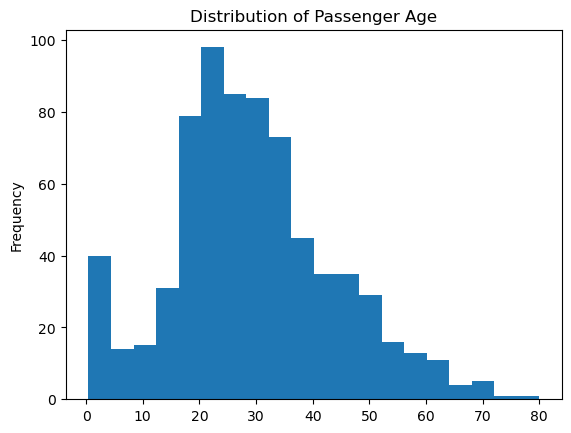

In [54]:
df_train['Age'].plot.hist(bins=20);
plt.title("Distribution of Passenger Age");

We see a spike close to 0; this implies there were a good number of infants on board.

Now let's view a correlation matrix and see if we can make any observations:

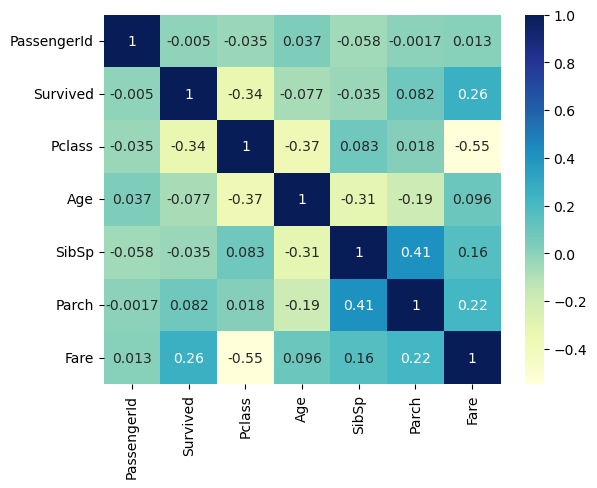

In [29]:
df_train_corr = df_train.corr()

fig, ax = plt.subplots()
ax = sns.heatmap(df_train_corr,
                 annot=True,
                 cmap="YlGnBu")

There appears to be a correlation between Survived and Fare (The amount a passenger paid for a ticket). 

Let's see the average fare for a passenger who survived vs. a passenger who deceased:

In [32]:
df_train.loc[df_train['Survived']==True]['Fare'].mean() # Survived

48.39540760233917

In [33]:
df_train.loc[df_train['Survived']==False]['Fare'].mean() # Deceased

22.117886885245877

Interesting. So on average, a passenger who survived paid more than twice what the average passenger who deceased paid. Similar to fare, let's check out how cabin class relates to survival:

In [35]:
pd.crosstab(df_train["Pclass"], df_train['Survived'])

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


Interesting again. Let's quickly compute the chance of survival based on Pclass for the three different classes:

In [42]:
# 1st Class survival chance (%)
136/(80+136)*100

62.96296296296296

In [43]:
# 2nd Class survival chance (%)
87/(97+87)*100

47.28260869565217

In [44]:
# 3rd Class survival chance (%)
119/(119+372)*100

24.236252545824847

We can see that the chances of surviving decreased a lot for lower class passengers

As we wrap up data exploration, let's also take a look at how Sex correlates with survived:

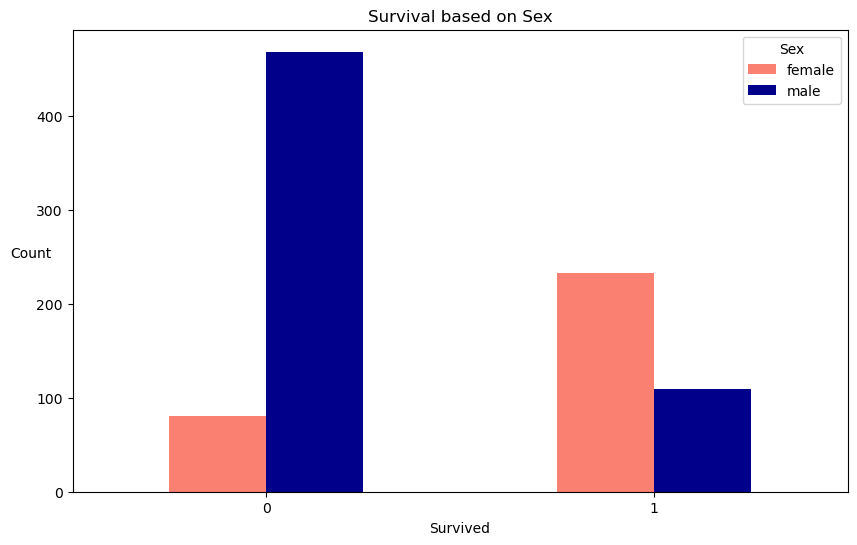

In [48]:
pd.crosstab(df_train["Survived"], df_train["Sex"]).plot(kind='bar',
                                                        figsize=(10,6),
                                                        color=['salmon', 'darkblue'])
plt.title("Survival based on Sex")
plt.ylabel("Count", rotation=0)
plt.xticks(rotation=0);

There appears to also be a correlation between survival and the sex of the passenger

In [89]:
# I want to see if age correlates to Survived as well. Here, we create two arrays that store the number of Survived and Deceased for age brackets of 5 years
age_survived = np.zeros(int(df_train["Age"].max()/5)+1)
age_deceased = np.zeros(int(df_train["Age"].max()/5)+1)
for i, j in df_train.iterrows():
    try:
        label = int(j.Age / 5)
    except ValueError:
        continue
    
    if j.Survived == True:
        age_survived[label] += 1
    else:
        age_deceased[label] += 1

In [94]:
age_df = pd.DataFrame({'Survived': age_survived,
                       'Deceased': age_deceased})

age_df

,Survived,Deceased
0,27.0,13.0
1,11.0,11.0
2,7.0,9.0
3,34.0,52.0
4,39.0,75.0
5,38.0,68.0
6,40.0,55.0
7,33.0,39.0
8,18.0,30.0
9,16.0,25.0


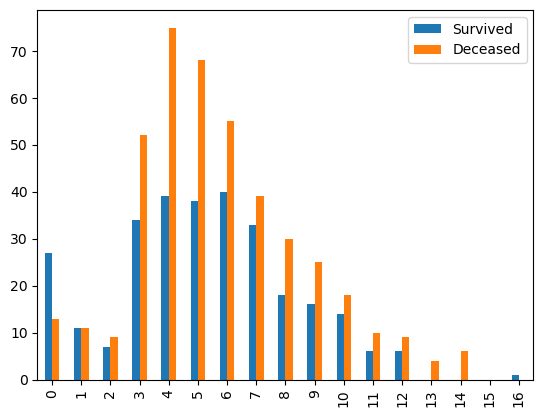

In [97]:
age_df.plot.bar();

These are absolute values, let's now make a dataframe and show a bar chart that reflects survival likelihood (%) for each 5-year age bracket

In [100]:
percent_survived = np.zeros(len(age_df))
for i, j in age_df.iterrows():
    if (j.Survived + j.Deceased) == 0:
        percent_survived[i] = 0
    else:
        per_sur = (j.Survived / (j.Survived + j.Deceased)) * 100
        percent_survived[i] = per_sur

percent_survived

array([ 67.5       ,  50.        ,  43.75      ,  39.53488372,
        34.21052632,  35.8490566 ,  42.10526316,  45.83333333,
        37.5       ,  39.02439024,  43.75      ,  37.5       ,
        40.        ,   0.        ,   0.        ,   0.        ,
       100.        ])

In [101]:
ps_df = pd.DataFrame(percent_survived)
ps_df

,0
0,67.500000
1,50.000000
2,43.750000
3,39.534884
4,34.210526
5,35.849057
6,42.105263
7,45.833333
8,37.500000
9,39.024390


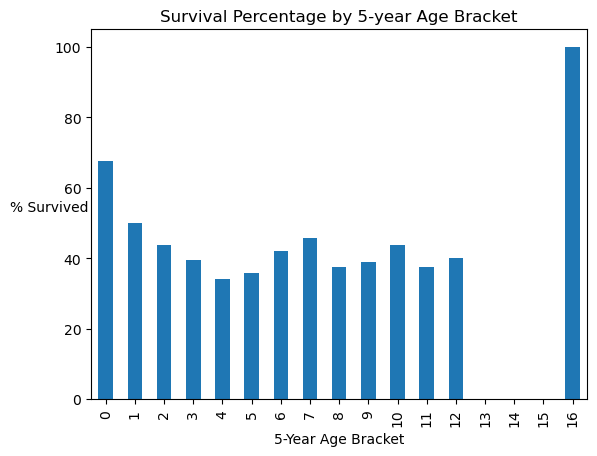

In [103]:
ps_df.plot.bar(legend=False)
plt.title("Survival Percentage by 5-year Age Bracket")
plt.ylabel("% Survived", rotation=0)
plt.xlabel("5-Year Age Bracket");

As shown in the graph, there appears to be a correlation with Survived for Passengers less than 10 years old, but no apparent correlation after that. The spike for bracket 16 only represents one passenger (who survived)

**From our preliminary data exploration, there appears to be correlations between Fare, Sex, Pclass, Age (not as strong) and our target column of 
Survived. An interesting experiment may be to train a model on only these columns and see how it performs**

**In fact, let's try it! We will perform steps 4 through 9 on a model that is fitted to only those four columns and see how it does. If it doesn't go well, we will revisit and restart step 4 with a more flushed out dataset**

## *4. Clean up the data and split it 

Note: The asterisk denotes that this is for our four-column fitting attempt

In [105]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's drop all columns except for Pclass, Sex, Age, Fare, and Survived

In [106]:
df_train.drop(["PassengerId", "Name", "SibSp", "Parch", "Ticket", "Cabin", "Embarked"], axis=1, inplace=True)

In [107]:
df_train.head()

,Survived,Pclass,Sex,Age,Fare
0,0,3,male,22.0,7.2500
1,1,1,female,38.0,71.2833
2,1,3,female,26.0,7.9250
3,1,1,female,35.0,53.1000
4,0,3,male,35.0,8.0500


In [108]:
df_train.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
Fare          0
dtype: int64

In [109]:
# Fill in missing age values with the median
df_train["Age"].fillna(df_train["Age"].median(), inplace=True)

In [115]:
df_train.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
Fare        0
dtype: int64

In [116]:
# Split into X and y
X = df_train.drop("Survived", axis=1)
y= df_train["Survived"]

# Convert non-numerical columns to categories and then to numbers
cat_features = ["Pclass", "Sex"]
one_hot = OneHotEncoder()

transformer = ColumnTransformer([("one_hot", one_hot, cat_features)],
                                remainder='passthrough')

transformed_X = transformer.fit_transform(X)
transformed_X

array([[ 0.    ,  0.    ,  1.    , ...,  1.    , 22.    ,  7.25  ],
       [ 1.    ,  0.    ,  0.    , ...,  0.    , 38.    , 71.2833],
       [ 0.    ,  0.    ,  1.    , ...,  0.    , 26.    ,  7.925 ],
       ...,
       [ 0.    ,  0.    ,  1.    , ...,  0.    , 28.    , 23.45  ],
       [ 1.    ,  0.    ,  0.    , ...,  1.    , 26.    , 30.    ],
       [ 0.    ,  0.    ,  1.    , ...,  1.    , 32.    ,  7.75  ]])

In [ ]:
# Let's now split our data into train and test sets
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(transformed_X, y, test_size=0.2)

In [118]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 7), (179, 7), (712,), (179,))

## *5. Modelling and Evaluation

Now that we've got our data split, let's fit a few models and see how they perform

In [124]:
models = {'Random Forest': RandomForestClassifier(),
          'K Neighbors': KNeighborsClassifier(),
          'Logistic Regression': LogisticRegression()}

def fit_and_score(model, X_train, X_test, y_train, y_test): #Let's create a function that we can pass a model and that fits and scores for us
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

for name, model in models.items():
    print(name, fit_and_score(model, X_train, X_test, y_train, y_test))

Random Forest 0.7932960893854749
K Neighbors 0.6983240223463687
Logistic Regression 0.7988826815642458


Considering we removed several columns from our dataset, these are pretty good scores! In my mind, it potentially indicates that we were justified in moving forward with fitting only a few columns that appeared to correlate to our target.

We can see that Random Forest and Logistic Regression performed best, so let's move forward with tuning these models and see which one performs better

## *6.Tune the model

Let's tune the Random Forest and Logistic Regression models using RandomizedSearchCV

In [125]:
# Set up our hyperparameter grids
rf_grid = {'n_estimators': np.arange(10, 750, 10),
           'max_depth': [None, 3, 5, 10, 15],
           'min_samples_split': np.arange(2, 20, 2),
           'min_samples_leaf': np.arange(1, 20, 2)}

lr_grid = {'C': np.logspace(-4, 4, 20),
           'solver': ['liblinear']}

In [127]:
#Let's do Random Forest first
rf_rs_clf = RandomizedSearchCV(RandomForestClassifier(),
                               param_distributions=rf_grid,
                               n_iter=25,
                               cv=5,
                               verbose=True)
rf_rs_clf.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=25,
                   param_distributions={'max_depth': [None, 3, 5, 10, 15],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520,
       530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650,
       660, 670, 680, 690, 700, 710, 720, 730, 740])},
                   verbose=True)

In [128]:
# Let's see our Random Forest model's best parameters
rf_rs_clf.best_params_

{'n_estimators': 200,
 'min_samples_split': 18,
 'min_samples_leaf': 1,
 'max_depth': 15}

In [129]:
# Let's score it!
rf_rs_clf.score(X_test, y_test)

0.8268156424581006

Not too bad, we see some improvement. Let's now do a RandomizedSearchCV optimization on our LogisticRegression model. Whichever of the two is better, we may do a more comprehensive hyperparameter tuning to increase our score

In [131]:
# Now let's do a RandomizedSearchCV on our LogisticRegression model
lr_rs_clf = RandomizedSearchCV(LogisticRegression(),
                               param_distributions=lr_grid,
                               n_iter=20, # We only have enough params in lr_grid for 20 iterations
                               cv=5,
                               verbose=True)
lr_rs_clf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [132]:
# Let's see our best LogisticRegression parameters
lr_rs_clf.best_params_

{'solver': 'liblinear', 'C': 0.23357214690901212}

In [133]:
# Let's score it!
lr_rs_clf.score(X_test, y_test)

0.7932960893854749

Not a very substantial change in score. Let's move forward with our RandomForestClassifier and try a more comprehensive hyperparameter tuning using GridSearchCV

In [142]:
rf_new_grid = {'n_estimators': np.arange(100, 500, 100),
               'max_depth': [None, 3, 5, 10, 15],
               'min_samples_split': np.arange(2, 20, 2),
               'min_samples_leaf': np.arange(1, 20, 2)}

In [143]:
# Comprehensive tuning using GridSearchCV
rf_gs_clf = GridSearchCV(RandomForestClassifier(),
                         param_grid=rf_new_grid,
                         n_jobs=-1,
                         cv=5,
                         verbose=True)
rf_gs_clf.fit(X_train, y_train)

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 5, 10, 15],
                         'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                         'n_estimators': array([100, 200, 300, 400])},
             verbose=True)

In [144]:
rf_gs_clf.best_params_

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 12,
 'n_estimators': 200}

In [145]:
# Let's score it!
rf_gs_clf.score(X_test, y_test)

0.8212290502793296

This accuracy score is about the same as from our RandomizedSearchCV attempt

We did not reach our score goal (accuracy > 0.90), but let's go ahead and import Kaggle's test set, run our model on it, and export our results

In [164]:
df_test = pd.read_csv("titanic/test.csv")
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [165]:
# Format our test set to reflect our train set
pass_id = df_test["PassengerId"] # Save passenger ids, we'll need these for our submission file
df_test.drop(["PassengerId", "Name", "SibSp", "Parch", "Ticket", "Cabin", "Embarked"], axis=1, inplace=True)
df_test.head()

,Pclass,Sex,Age,Fare
0,3,male,34.5,7.8292
1,3,female,47.0,7.0000
2,2,male,62.0,9.6875
3,3,male,27.0,8.6625
4,3,female,22.0,12.2875


In [166]:
pass_id

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [167]:
df_test.isna().sum()

Pclass     0
Sex        0
Age       86
Fare       1
dtype: int64

In [168]:
# Fill missing age values with the median
df_test["Age"].fillna(df_test["Age"].median(), inplace=True)

# Fill missing fare value with the median
df_test["Fare"].fillna(df_test["Fare"].median(), inplace=True)

In [169]:
df_test.isna().sum()

Pclass    0
Sex       0
Age       0
Fare      0
dtype: int64

In [170]:
# Convert non-numerical columns to categories and then to numbers
cat_features = ["Pclass", "Sex"]
one_hot = OneHotEncoder()

transformer = ColumnTransformer([("one_hot", one_hot, cat_features)],
                                remainder='passthrough')

transformed_df_test = transformer.fit_transform(df_test)
transformed_df_test

array([[ 0.    ,  0.    ,  1.    , ...,  1.    , 34.5   ,  7.8292],
       [ 0.    ,  0.    ,  1.    , ...,  0.    , 47.    ,  7.    ],
       [ 0.    ,  1.    ,  0.    , ...,  1.    , 62.    ,  9.6875],
       ...,
       [ 0.    ,  0.    ,  1.    , ...,  1.    , 38.5   ,  7.25  ],
       [ 0.    ,  0.    ,  1.    , ...,  1.    , 27.    ,  8.05  ],
       [ 0.    ,  0.    ,  1.    , ...,  1.    , 27.    , 22.3583]])

In [171]:
# Make predictions on our test dataset
y_preds = rf_gs_clf.predict(transformed_df_test)
y_preds

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

## *7. Export deliverables

In [174]:
predictions = pd.DataFrame({'PassengerId': pass_id,
                           'Survived': y_preds})

In [175]:
predictions

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [176]:
predictions.shape

(418, 2)

In [178]:
# Export predictions to csv
titanic_survivors = predictions.to_csv("titanic/titanic-survivors.csv", index=False)

## *8. Reflection

Some ideas for how we could improve our classification project in the future:
   * Consider keeping all or a few of the columns that we dropped and using those in our model
   * Research other classification models to use
   * Keep the K Neighbors model and try tuning it
   * Run longer hyperparameter tuning experiments on our RandomForest and LogisticRegression models